# Import all libraries

In [1]:
import numpy as np
import torch
import networkx as nx
from tqdm import tqdm

from Architecture.Layers import Random_RNN
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    !nvidia-smi
    print(torch.cuda.get_device_name(0))

else:
    print("No GPU :(")

Sat Apr 29 22:20:50 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti      Off| 00000000:01:00.0  On |                  N/A |
| N/A   44C    P0               17W /  N/A|    797MiB /  4096MiB |     24%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
input_size = 2
hidden_size = 5
output_size = 3
# device = "cpu"

model = Random_RNN(input_size, output_size, hidden_size, connect_percentage=0.0).to(device)

print(f'nodes: {len(model.graph.nodes)}\n edges: {len(model.graph.edges)}')

nodes: 10
 edges: 15


In [4]:
# Create test data vector and forward the model
model.reset_neurons_memory()
model.reset_neurons_states()

test_individ = torch.ones(input_size)
out, time = model.forward(test_individ.view(-1, input_size), return_work_time=True)
print(f"Output: {out.detach().numpy()} \nWork time of network: {time} iter.")

Output: [-0.1353127   0.01541885 -0.17485873] 
Work time of network: 3 iter.


In [5]:
# # Show all nodes data
# for i, data in model.graph.nodes(data=True):
#     print(i, data['type'], data['status'])

In [6]:
# from torchsummary import summary

# show model summary
# summary(model, (input_size, ), device='cpu')
# model.graph.edges()

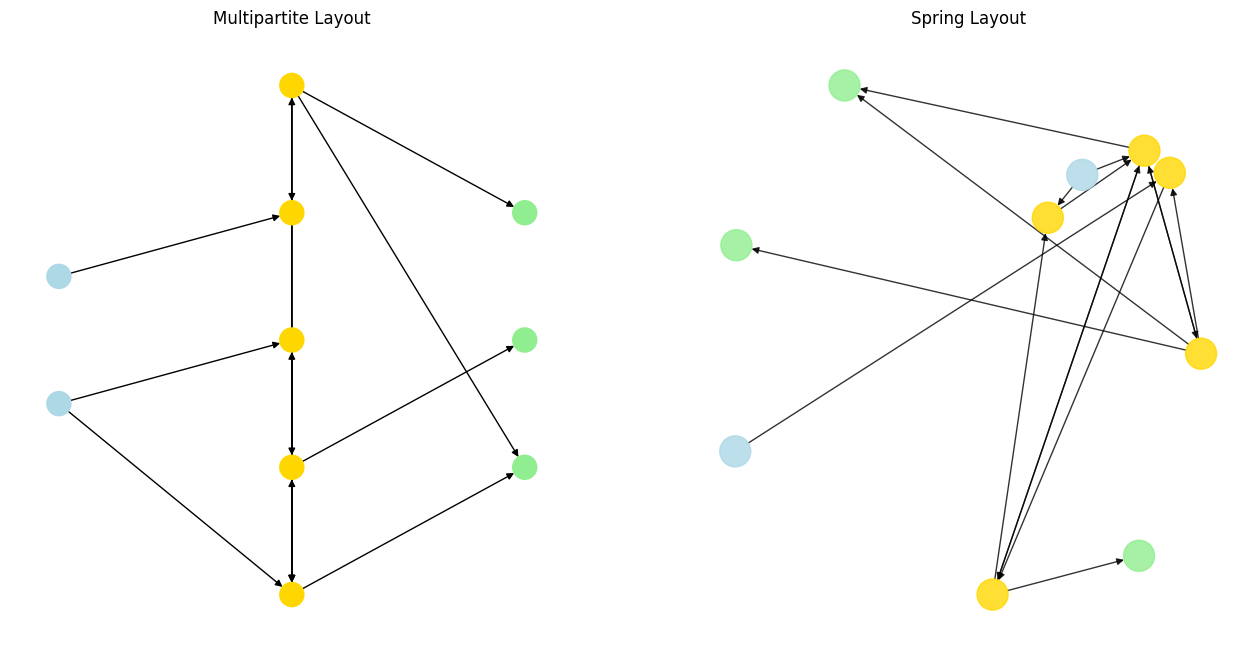

In [7]:
def draw_graph(model):
    plt.figure(figsize=(16, 8))

    plt.subplot(121)
    pos = nx.multipartite_layout(model.graph, subset_key="layer")
    nx.draw(model.graph, pos, node_color=[n[1]["color"] for n in model.graph.nodes(data=True)], with_labels=False)
    plt.title('Multipartite Layout')

    plt.subplot(122)
    nx.draw(model.graph, node_color=[n[1]["color"] for n in model.graph.nodes(data=True)], node_size=500, alpha=0.8, with_labels=False)
    plt.title('Spring Layout')

    plt.show()

draw_graph(model)

# Dataset
The dataset consist of 3 clusters in 2 dimension space.

In [8]:
from sklearn.datasets import make_blobs

# Generate points
X, Y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=0.7, random_state=0)

# Normalize dataset
X = (X - X.min()) / (X.max() - X.min())

# Convert Y to one-hot
Y = np.eye(3)[Y]

# Convert to tensors
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

# Create dataset
dataset = torch.utils.data.TensorDataset(X, Y)

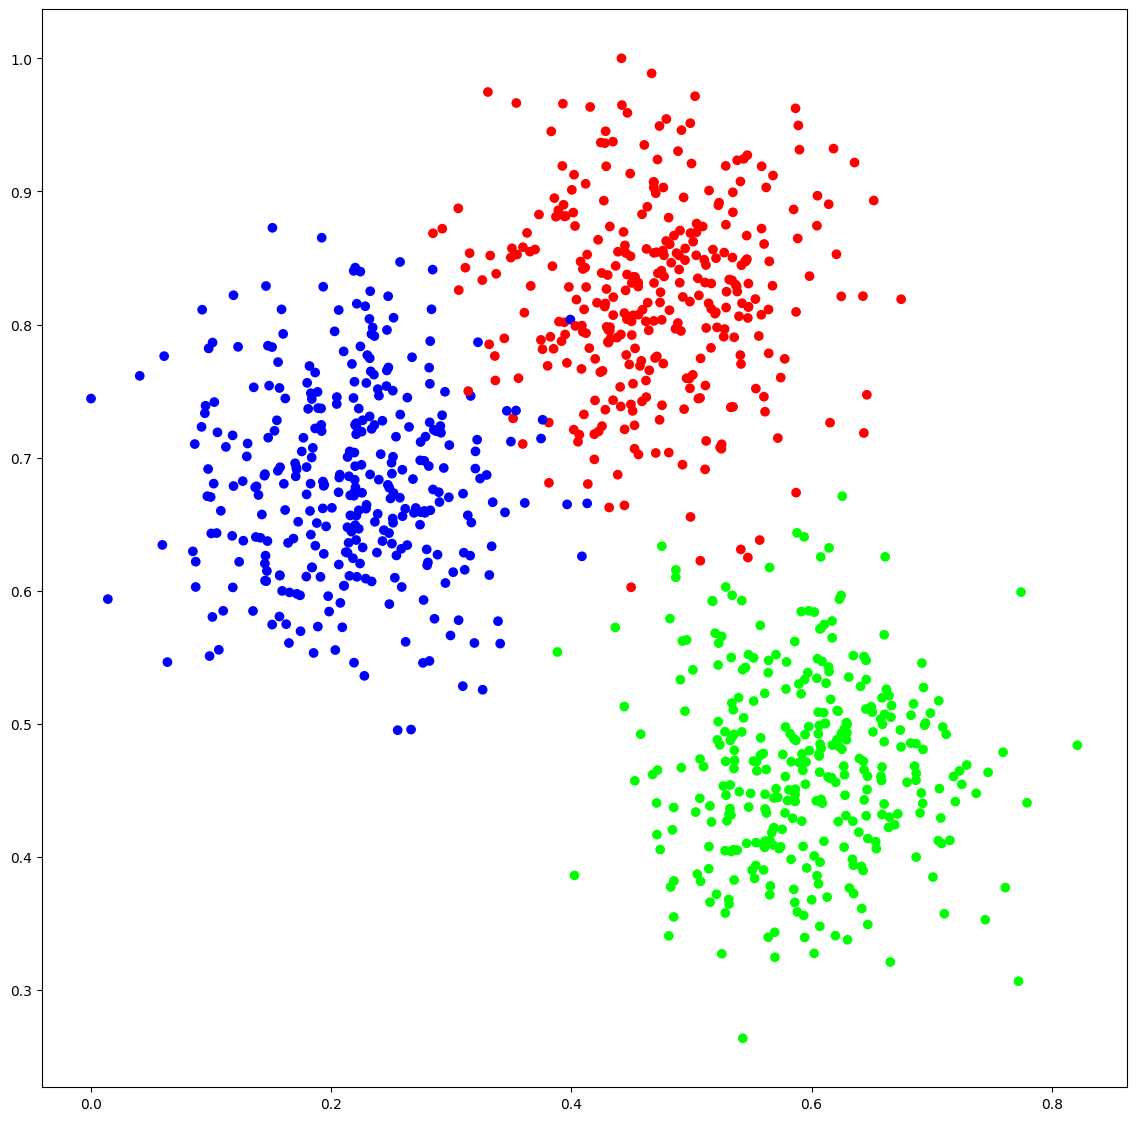

In [9]:
# Visualize dataset
plt.figure(figsize = (14, 14))
plt.scatter([i[0] for i in X], [i[1] for i in X], c=Y)
plt.show()

In [10]:
split_ratio = 0.90
batch_size = 1
train_size = round(len(dataset) * split_ratio)
valid_size = len(dataset) - train_size

train, valid = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_batch_loader = torch.utils.data.DataLoader2(train, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))
valid_batch_loader = torch.utils.data.DataLoader2(valid, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

# Validate untrained model
Validating the model with random initialized weights (not trained)

In [11]:
from sklearn.metrics import f1_score, accuracy_score

def validate(model, valid_batch_loader):
    # Create empty lists to store predictions and labels
    predictions = []
    labels = []

    # Iterate over validation set
    for i, (features, ans) in enumerate(valid_batch_loader):
        # Forward pass
        Y_pred, time = model.forward(features.view(-1, input_size), return_work_time=True)

        # Get prediction
        prediction = torch.argmax(Y_pred, dim=0).item()

        # Append to lists
        predictions.append(prediction)
        labels.append(torch.argmax(ans, dim=1).item())

    # Calculate metrics
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return f1, acc

In [12]:
sample_size = 20
f1 = []
acc = []
for i in tqdm(range(sample_size), desc='Validation', leave=False, colour='green'):
    model.restruct(connect_percentage=0.0)
    f1_i, acc_i = validate(model, valid_batch_loader)
    f1.append(f1_i)
    acc.append(acc_i)

print(f'F1: {np.mean(f1)}\nACC: {np.mean(acc)}')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

# Train loop

In [ ]:
model.restruct(connect_percentage=0.0)
draw_graph(model)

In [ ]:
# Configure hyper-parameters
epochs = 2
learning_rate = 3e-4
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = []

In [ ]:
for epoch in range(0, epochs):
    for i, (features, ans) in enumerate(tqdm(train_batch_loader, desc=f"Epoch {epoch + 1}", leave=False, colour='green')):

        # Forward pass
        Y_pred = model.forward(features.view(-1, input_size))
        # print(Y_pred, ans)

        # Calculate loss
        loss = loss_func(Y_pred.view(3, ), ans.view(3, ))

        # Backward pass
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()

        history.append(loss.data)

In [ ]:
# Plot loss history
plt.figure(figsize=(16, 8))
plt.plot(history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.show()

# Validate trained model

In [ ]:
f1, acc = validate(model, valid_batch_loader)
print(f'F1: {f1}\nACC: {acc}')

# Load MNIST

In [ ]:
import torchvision
dataset = torchvision.datasets.MNIST(root = 'datasets', train = True, download = True, transform=torchvision.transforms.ToTensor())

#### Get and visualize random individual

In [ ]:
rand_individ = np.random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]
plt.imshow(img, cmap='plasma')
plt.xlabel(f"NUMBER: {ans}")
pass

# Prepare and split data into train/test

In [ ]:
split_ratio = 0.00005
batch_size = 1
train_size = round(len(dataset) * split_ratio)
valid_size = len(dataset) - train_size

# print(dataset.shape)
print(dataset)

train, valid = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_batch_loader = torch.utils.data.DataLoader2(train, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))
valid_batch_loader = torch.utils.data.DataLoader2(valid, batch_size=batch_size, collate_fn=lambda x: tuple(x_.to(device) for x_ in torch.utils.data.dataloader.default_collate(x)))

# Configure NN Model and hyper-parameters

# Train loop

# Validation

# Visualisation test

In [ ]:
rand_individ = random.randint(0, 60_000)
img = dataset[rand_individ][0].view((28, 28))
ans = dataset[rand_individ][1]


with torch.no_grad():
    pred = mnist_nn(img.to(device).view(-1)).argmax()

plt.imshow(img, cmap='Greys')
plt.xlabel(f"PREDICTION: {pred}, ANSWER {ans}")
pass